In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Activation, Dense,LSTM,Dropout
from sklearn.metrics import mean_absolute_error
plt.style.use('fivethirtyeight')

In [2]:
import requests
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, LSTM
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
%matplotlib inline

In [3]:
# Database related all the code is moved to this file
%run -i "SqlConn.py"
#importing local py file
import SqlConn 

In [4]:
#Fetch Tweets and Sentiment data - Join from Tweet and Sentiment tables
try:
    df_dbFinanceData = SqlConn.fetchFinanceData("")
    print("Data transfer Done")
except BaseException as err:
    print(err)

Data transfer Done


In [5]:
df_dbFinanceData

,financeType,date,open,high,low,close,adjustedClose,volume,id
0,tesla,2010-06-29,3.800000,5.000000,3.508000,4.778000,4.778000,93831500,1
1,tesla,2010-06-30,5.158000,6.084000,4.660000,4.766000,4.766000,85935500,2
2,tesla,2010-07-01,5.000000,5.184000,4.054000,4.392000,4.392000,41094000,3
3,tesla,2010-07-02,4.600000,4.620000,3.742000,3.840000,3.840000,25699000,4
4,tesla,2010-07-06,4.000000,4.000000,3.166000,3.222000,3.222000,34334500,5
...,...,...,...,...,...,...,...,...,...
6916,doge,2022-07-09,0.069224,0.070009,0.068995,0.069512,0.069512,254272147,6917
6917,doge,2022-07-10,0.069509,0.069509,0.066533,0.067263,0.067263,299810124,6918
6918,doge,2022-07-11,0.067268,0.067268,0.061535,0.061847,0.061847,326125900,6919
6919,doge,2022-07-12,0.061851,0.062861,0.060087,0.060087,0.060087,298462083,6920


In [6]:
tesla_price = df_dbFinanceData[df_dbFinanceData["financeType"] == "tesla"]

In [7]:
tesla_price

,financeType,date,open,high,low,close,adjustedClose,volume,id
0,tesla,2010-06-29,3.800000,5.000000,3.508000,4.778000,4.778000,93831500,1
1,tesla,2010-06-30,5.158000,6.084000,4.660000,4.766000,4.766000,85935500,2
2,tesla,2010-07-01,5.000000,5.184000,4.054000,4.392000,4.392000,41094000,3
3,tesla,2010-07-02,4.600000,4.620000,3.742000,3.840000,3.840000,25699000,4
4,tesla,2010-07-06,4.000000,4.000000,3.166000,3.222000,3.222000,34334500,5
...,...,...,...,...,...,...,...,...,...
3025,tesla,2022-07-06,692.340027,703.690002,681.559998,695.200012,695.200012,23951200,3026
3026,tesla,2022-07-07,701.760010,736.090027,696.630005,733.630005,733.630005,27310200,3027
3027,tesla,2022-07-08,727.000000,764.940002,723.479980,752.289978,752.289978,33343700,3028
3028,tesla,2022-07-11,756.309998,759.190002,700.880005,703.030029,703.030029,33080400,3029


In [8]:
end_date = tesla_price['date'].iloc[-1]
end_date

'2022-07-12'

In [9]:
tesla_price['date'] = pd.to_datetime(tesla_price['date'], format='%Y-%m-%d')

SqlConn.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [10]:
tesla_price.dtypes

financeType              object
date             datetime64[ns]
open                    float64
high                    float64
low                     float64
close                   float64
adjustedClose           float64
volume                    int64
id                        int64
dtype: object

In [11]:
tesla_price.set_index("date",inplace = True)

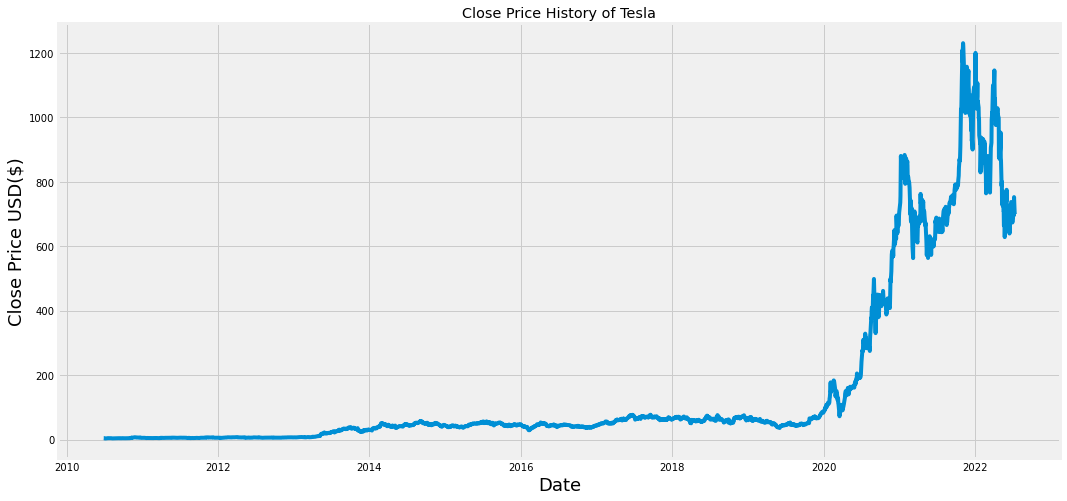

In [12]:
plt.figure(figsize=(16,8))
plt.title('Close Price History of Tesla')
plt.plot(tesla_price['close'])
plt.xlabel('Date',fontsize=18)
plt.ylabel('Close Price USD($)',fontsize=18)
plt.show()

In [13]:
data = tesla_price.drop(['financeType','open', 'high', 'low', 'adjustedClose', 'volume','id'], axis = 1)
price_column = 'close'
data.head()

,close
date,
2010-06-29,4.778
2010-06-30,4.766
2010-07-01,4.392
2010-07-02,3.840
2010-07-06,3.222


In [14]:
# This function splits the data in 70,30 ratio.
def train_test_split(df, test_size=0.3):
    split_row = len(df) - int(test_size * len(df))
    train_data = df.iloc[:split_row]
    test_data = df.iloc[split_row:]
    return train_data, test_data

In [15]:
train, test = train_test_split(data, test_size=0.2)

In [16]:
train.shape, test.shape

((2424, 1), (606, 1))

In [17]:
train

,close
date,
2010-06-29,4.778000
2010-06-30,4.766000
2010-07-01,4.392000
2010-07-02,3.840000
2010-07-06,3.222000
...,...
2020-02-07,149.613998
2020-02-10,154.255997
2020-02-11,154.876007


In [18]:
test

,close
date,
2020-02-14,160.005997
2020-02-18,171.679993
2020-02-19,183.483994
2020-02-20,179.882004
2020-02-21,180.199997
...,...
2022-07-06,695.200012
2022-07-07,733.630005
2022-07-08,752.289978


In [19]:
# Perform MinMax scaling
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(data).reshape(-1,1))
df1

array([[0.00131893],
       [0.00130915],
       [0.00100428],
       ...,
       [0.61066228],
       [0.57050745],
       [0.56739352]])

In [20]:
##splitting dataset into train and test split
training_size=int(len(df1)*0.8)
# test_size=len(df1)-training_size

test_size = 0.2
split_row = len(df1) - int(test_size * len(df1))
# train_data = df.iloc[:split_row]
# test_data = df.iloc[split_row:]
    
train_scaled,test_scaled=df1[0:split_row,:],df1[split_row:,]
training_size,split_row

(2424, 2424)

In [21]:
train_scaled.shape,test_scaled.shape

((2424, 1), (606, 1))

In [22]:
train_scaled

array([[0.00131893],
       [0.00130915],
       [0.00100428],
       ...,
       [0.12367312],
       [0.12251721],
       [0.12850214]])

In [23]:
test_scaled

array([[0.1278549 ],
       [0.13737109],
       [0.14699327],
       [0.14405706],
       [0.14431628],
       [0.13335887],
       [0.12783533],
       [0.12439372],
       [0.10812309],
       [0.10632811],
       [0.11865824],
       [0.11896638],
       [0.11961687],
       [0.11554759],
       [0.11211412],
       [0.09654778],
       [0.10263378],
       [0.10082413],
       [0.0888119 ],
       [0.08654086],
       [0.06998492],
       [0.06756063],
       [0.05631465],
       [0.06714326],
       [0.06712533],
       [0.06822743],
       [0.07975545],
       [0.08533931],
       [0.08353128],
       [0.08128143],
       [0.07928755],
       [0.08285307],
       [0.07593397],
       [0.07151742],
       [0.07568127],
       [0.08158793],
       [0.08635011],
       [0.08690279],
       [0.09084165],
       [0.10355003],
       [0.11315915],
       [0.11641003],
       [0.11891747],
       [0.12033258],
       [0.11910495],
       [0.10938169],
       [0.11678173],
       [0.112

In [24]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [25]:
# reshape into X=t,t+1,t+2,t+3 and Y=t+4
time_step = 160
X_train, y_train = create_dataset(train_scaled, time_step)
X_test, ytest = create_dataset(test_scaled, time_step)

In [26]:
print(X_train.shape), print(y_train.shape)

(2263, 160)
(2263,)


(None, None)

In [27]:
print(X_test.shape), print(ytest.shape)

(445, 160)
(445,)


(None, None)

In [28]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [29]:
print(X_train.shape), print(y_train.shape)

(2263, 160, 1)
(2263,)


(None, None)

In [30]:
print(X_test.shape), print(ytest.shape)

(445, 160, 1)
(445,)


(None, None)

In [31]:
X_test

array([[[0.1278549 ],
        [0.13737109],
        [0.14699327],
        ...,
        [0.33903403],
        [0.34713674],
        [0.36274709]],

       [[0.13737109],
        [0.14699327],
        [0.14405706],
        ...,
        [0.34713674],
        [0.36274709],
        [0.33578968]],

       [[0.14699327],
        [0.14405706],
        [0.14431628],
        ...,
        [0.36274709],
        [0.33578968],
        [0.34442224]],

       ...,

       [[0.82350111],
        [0.85719988],
        [0.88514366],
        ...,
        [0.55319336],
        [0.56738536],
        [0.56412471]],

       [[0.85719988],
        [0.88514366],
        [0.8911514 ],
        ...,
        [0.56738536],
        [0.56412471],
        [0.59545138]],

       [[0.88514366],
        [0.8911514 ],
        [0.92431223],
        ...,
        [0.56412471],
        [0.59545138],
        [0.61066228]]])

In [32]:
ytest

array([0.33578968, 0.34442224, 0.33488486, 0.34411247, 0.34461789,
       0.35120439, 0.35797023, 0.36151619, 0.3734583 , 0.36333401,
       0.35582637, 0.34862032, 0.34137354, 0.34194416, 0.34451192,
       0.34030568, 0.34002037, 0.34360708, 0.32839615, 0.33231708,
       0.31373955, 0.32390463, 0.34297125, 0.34059099, 0.3545384 ,
       0.347903  , 0.34081924, 0.33193395, 0.33745261, 0.3330752 ,
       0.33041776, 0.33008354, 0.35740776, 0.39411453, 0.40441001,
       0.39653554, 0.42281635, 0.45014876, 0.46532707, 0.47491338,
       0.46011001, 0.47409822, 0.46110454, 0.48112491, 0.48573871,
       0.52056246, 0.52718157, 0.49017319, 0.50858772, 0.49466474,
       0.5189892 , 0.51362542, 0.50508254, 0.53208886, 0.56396167,
       0.52716525, 0.51940494, 0.52400241, 0.53687386, 0.53843895,
       0.54031381, 0.56378236, 0.57265944, 0.59230487, 0.59665781,
       0.61367023, 0.66262886, 0.71478296, 0.65867535, 0.68985529,
       0.69390662, 0.68623597, 0.6708783 , 0.68586914, 0.69067

In [33]:
np.random.seed(42)
tf.random.set_seed(42)
window_len = 160
test_size = 0.2
zero_base = True
lstm_neurons = 100
epochs = 100
batch_size = 32
loss = 'mse'
dropout = 0.2
optimizer = 'adam'
activ_func = "relu"

In [34]:
# model = Sequential()
# model.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2])))
# model.add(Dropout(dropout))
# model.add(Dense(units=1))
# model.add(Activation(activ_func))
# model.compile(loss=loss, optimizer=optimizer)
# model.summary()

In [35]:
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [36]:
history = model.fit(
    X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1, shuffle=True)

Epoch 1/100
71/71 [==============================] - 19s 165ms/step - loss: 1.1573e-04
Epoch 2/100
71/71 [==============================] - 11s 157ms/step - loss: 1.6379e-05
Epoch 3/100
71/71 [==============================] - 12s 174ms/step - loss: 1.5892e-05
Epoch 4/100
71/71 [==============================] - 14s 193ms/step - loss: 1.4771e-05
Epoch 5/100
71/71 [==============================] - 13s 178ms/step - loss: 1.3851e-05
Epoch 6/100
71/71 [==============================] - 13s 179ms/step - loss: 1.1684e-05
Epoch 7/100
71/71 [==============================] - 12s 176ms/step - loss: 1.2814e-05
Epoch 8/100
71/71 [==============================] - 15s 205ms/step - loss: 1.0523e-05
Epoch 9/100
71/71 [==============================] - 13s 178ms/step - loss: 8.7583e-06
Epoch 10/100
71/71 [==============================] - 12s 175ms/step - loss: 9.4807e-06
Epoch 11/100
71/71 [==============================] - 13s 178ms/step - loss: 9.2349e-06
Epoch 12/100
71/71 [=====================

71/71 [==============================] - 16s 222ms/step - loss: 3.6486e-06
Epoch 95/100
71/71 [==============================] - 14s 203ms/step - loss: 2.2801e-06
Epoch 96/100
71/71 [==============================] - 15s 217ms/step - loss: 2.6767e-06
Epoch 97/100
71/71 [==============================] - 15s 212ms/step - loss: 2.5303e-06
Epoch 98/100
71/71 [==============================] - 15s 209ms/step - loss: 2.3481e-06
Epoch 99/100
71/71 [==============================] - 14s 191ms/step - loss: 2.2119e-06
Epoch 100/100
71/71 [==============================] - 13s 189ms/step - loss: 2.6655e-06


In [37]:
### Lets Do the prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

14/14 [==============================] - 1s 64ms/step


In [38]:
test_predict

array([[0.3860771 ],
       [0.36172026],
       [0.36891696],
       [0.36098665],
       [0.36953628],
       [0.3705377 ],
       [0.3766577 ],
       [0.38335395],
       [0.38716546],
       [0.39889085],
       [0.39049006],
       [0.38329285],
       [0.37660864],
       [0.36968058],
       [0.3698014 ],
       [0.37191826],
       [0.3674945 ],
       [0.36643022],
       [0.36943057],
       [0.35484   ],
       [0.35752407],
       [0.33983004],
       [0.34829155],
       [0.3666151 ],
       [0.36488608],
       [0.37761897],
       [0.37229705],
       [0.36565116],
       [0.35743764],
       [0.36274663],
       [0.35906428],
       [0.35612372],
       [0.35540918],
       [0.38107622],
       [0.41690102],
       [0.4288529 ],
       [0.42283008],
       [0.44828933],
       [0.4773002 ],
       [0.49518153],
       [0.5071014 ],
       [0.4965874 ],
       [0.51037765],
       [0.5015865 ],
       [0.52010345],
       [0.5267963 ],
       [0.5590446 ],
       [0.568

In [39]:
### Calculate RMSE performance metrics
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))

0.001793172418289321

In [40]:
### Test Data RMSE
math.sqrt(mean_squared_error(ytest,test_predict))

0.0719952887231495

In [41]:
# Calculate the Mean Absolute Error
from sklearn.metrics import mean_absolute_error
mae=mean_absolute_error(ytest,test_predict)
mae

0.06327882756197288

In [42]:
# Calculate Mean Absolute error using Sklearn library
from sklearn.metrics import mean_absolute_percentage_error
mean_absolute_percentage_error(ytest,test_predict)

0.09998958281762926

In [43]:
# Manual calculation of Mean Absolute Percentage error.
total = 0
for i,j in zip(ytest, test_predict):
    value = abs(i-j)/abs(i)
    total+= value
#     print(total)
error = float(total*100/(len(ytest))) # Calculate MAPE
mape = round(error,2) # round to 3 significant figures
print(mape)

10.0


In [44]:
##Transformback to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [45]:
test_predict

array([[ 476.7801 ],
       [ 446.90033],
       [ 455.72888],
       [ 446.00037],
       [ 456.48865],
       [ 457.71713],
       [ 465.22482],
       [ 473.43945],
       [ 478.11523],
       [ 492.49936],
       [ 482.19366],
       [ 473.3645 ],
       [ 465.16464],
       [ 456.66565],
       [ 456.81387],
       [ 459.41074],
       [ 453.9839 ],
       [ 452.67828],
       [ 456.35895],
       [ 438.46   ],
       [ 441.75266],
       [ 420.0465 ],
       [ 430.42667],
       [ 452.90506],
       [ 450.784  ],
       [ 466.40408],
       [ 459.8754 ],
       [ 451.72256],
       [ 441.64664],
       [ 448.15942],
       [ 443.64212],
       [ 440.03476],
       [ 439.1582 ],
       [ 470.64526],
       [ 514.5933 ],
       [ 529.2553 ],
       [ 521.8668 ],
       [ 553.09894],
       [ 588.68805],
       [ 610.62396],
       [ 625.2467 ],
       [ 612.3486 ],
       [ 629.2658 ],
       [ 618.48126],
       [ 641.19696],
       [ 649.4074 ],
       [ 688.968  ],
       [ 700.

In [46]:
test_predict.shape

(445, 1)

In [47]:
targets = test[price_column][window_len+1:]
targets

date
2020-10-05    425.679993
2020-10-06    413.980011
2020-10-07    425.299988
2020-10-08    425.920013
2020-10-09    434.000000
                 ...    
2022-07-06    695.200012
2022-07-07    733.630005
2022-07-08    752.289978
2022-07-11    703.030029
2022-07-12    699.210022
Name: close, Length: 445, dtype: float64

In [48]:
preds = pd.Series(index=targets.index, data=test_predict.squeeze())
preds

date
2020-10-05    476.780090
2020-10-06    446.900330
2020-10-07    455.728882
2020-10-08    446.000366
2020-10-09    456.488647
                 ...    
2022-07-06    751.093079
2022-07-07    766.396179
2022-07-08    763.794861
2022-07-11    795.879272
2022-07-12    816.111389
Length: 445, dtype: float32

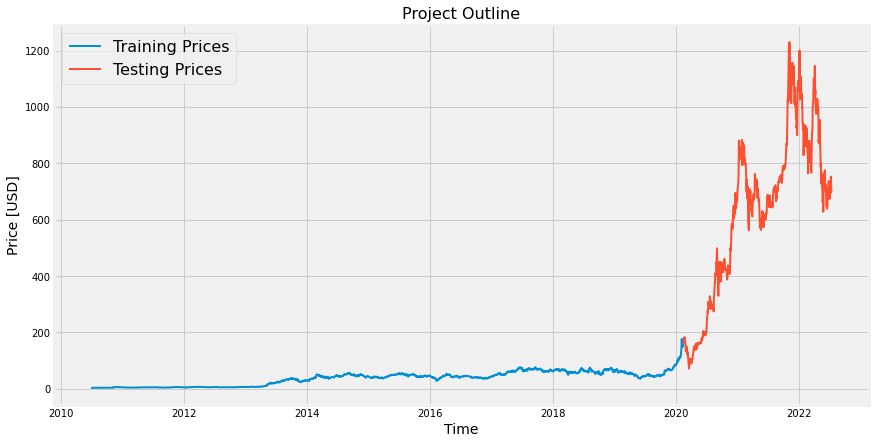

In [49]:
def line_plot(line1, line2, label1=None, label2=None, title='', lw=2):
    fig, ax = plt.subplots(1, figsize=(13, 7))
    ax.plot(line1, label=label1, linewidth=lw)
    ax.plot(line2, label=label2, linewidth=lw)
    ax.set_ylabel('Price [USD]', fontsize=14)
    ax.set_xlabel('Time', fontsize = 14)
    ax.set_title(title, fontsize=16)
    ax.legend(loc='best', fontsize=16)
line_plot(train["close"], test["close"], 'Training Prices', 'Testing Prices', title='Project Outline')

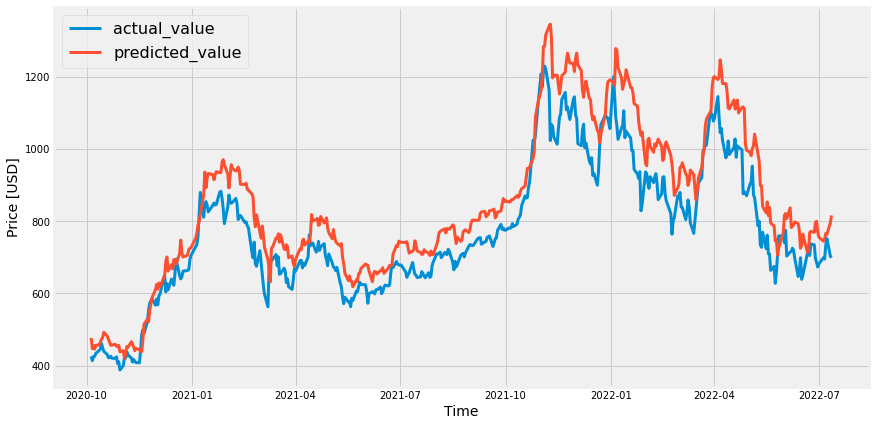

In [50]:
line_plot(targets, preds, 'actual_value', 'predicted_value', lw=3)

### Future Prediction for 30 days

In [51]:
len(test)

606

In [52]:
length = len(test_scaled)
length

606

In [53]:
#Getting the last 100 days records
fut_inp = test_scaled[length-160:]
fut_inp.shape

(160, 1)

In [54]:
fut_inp = fut_inp.reshape(1,-1)

In [55]:
fut_inp.shape

(1, 160)

In [56]:
fut_inp

array([[0.92431223, 0.94046054, 0.90146321, 0.90714487, 0.87936419,
        0.92425511, 0.93058894, 0.89002647, 0.88154876, 0.82478903,
        0.8199307 , 0.85477071, 0.86879962, 0.81568368, 0.82646831,
        0.78520477, 0.77876502, 0.79301403, 0.75301403, 0.75761971,
        0.73102097, 0.7624781 , 0.81981656, 0.86720193, 0.88916235,
        0.88470344, 0.88284484, 0.86992455, 0.858871  , 0.97543917,
        0.93452613, 0.88441815, 0.86532702, 0.83456281, 0.85996329,
        0.86508253, 0.89917256, 0.83831264, 0.85302625, 0.83745668,
        0.80904014, 0.80954554, 0.76685551, 0.75552474, 0.74606888,
        0.76156507, 0.67327488, 0.68733642, 0.7610026 , 0.75654369,
        0.73568367, 0.72384756, 0.75007946, 0.73705319, 0.74900344,
        0.75715506, 0.73477886, 0.6984634 , 0.71131036, 0.74935396,
        0.75013653, 0.71179128, 0.69600159, 0.66710414, 0.62024044,
        0.65018137, 0.65759933, 0.70696553, 0.70202565, 0.71467698,
        0.68158138, 0.68076622, 0.65328714, 0.66

In [57]:
tmp_inp = list(fut_inp)

In [58]:
tmp_inp

[array([0.92431223, 0.94046054, 0.90146321, 0.90714487, 0.87936419,
        0.92425511, 0.93058894, 0.89002647, 0.88154876, 0.82478903,
        0.8199307 , 0.85477071, 0.86879962, 0.81568368, 0.82646831,
        0.78520477, 0.77876502, 0.79301403, 0.75301403, 0.75761971,
        0.73102097, 0.7624781 , 0.81981656, 0.86720193, 0.88916235,
        0.88470344, 0.88284484, 0.86992455, 0.858871  , 0.97543917,
        0.93452613, 0.88441815, 0.86532702, 0.83456281, 0.85996329,
        0.86508253, 0.89917256, 0.83831264, 0.85302625, 0.83745668,
        0.80904014, 0.80954554, 0.76685551, 0.75552474, 0.74606888,
        0.76156507, 0.67327488, 0.68733642, 0.7610026 , 0.75654369,
        0.73568367, 0.72384756, 0.75007946, 0.73705319, 0.74900344,
        0.75715506, 0.73477886, 0.6984634 , 0.71131036, 0.74935396,
        0.75013653, 0.71179128, 0.69600159, 0.66710414, 0.62024044,
        0.65018137, 0.65759933, 0.70696553, 0.70202565, 0.71467698,
        0.68158138, 0.68076622, 0.65328714, 0.66

In [59]:
#Creating list of the last 100 data
tmp_inp = tmp_inp[0].tolist()

In [60]:
tmp_inp

[0.9243122295279268,
 0.9404605363964474,
 0.9014632144693302,
 0.9071448699059096,
 0.879364185124612,
 0.9242551119423895,
 0.9305889369145924,
 0.8900264680979011,
 0.8815487638290949,
 0.824789030329874,
 0.8199306966556807,
 0.8547707119933123,
 0.868799618064653,
 0.8156836847497492,
 0.8264683113104361,
 0.7852047656841558,
 0.7787650161173748,
 0.7930140314143249,
 0.7530140268168112,
 0.7576197116290442,
 0.7310209717915526,
 0.7624780950281189,
 0.8198165617495309,
 0.8672019323538899,
 0.8891623482930348,
 0.8847034366579036,
 0.8828448428638888,
 0.8699245456878464,
 0.8588710004470235,
 0.9754391651396523,
 0.9345261334633068,
 0.8844181495249913,
 0.86532701983198,
 0.8345628144486362,
 0.859963289799265,
 0.8650825307415481,
 0.899172561995625,
 0.8383126394924559,
 0.8530262531054473,
 0.837456679459118,
 0.8090401438700919,
 0.8095455410437756,
 0.766855510843214,
 0.7555247396064063,
 0.7460688800763466,
 0.761565067949287,
 0.6732748751649923,
 0.687336419507285,
 0.

In [61]:
#Predicting next 30 days price suing the current data
#It will predict in sliding window manner (algorithm) with stride 1
lst_output=[]
n_steps=160
i=0
while(i<30):
    
    if(len(tmp_inp)>160):
        fut_inp = np.array(tmp_inp[1:])
        fut_inp=fut_inp.reshape(1,-1)
        fut_inp = fut_inp.reshape((1, n_steps, 1))
        yhat = model.predict(fut_inp, verbose=0)
        tmp_inp.extend(yhat[0].tolist())
        tmp_inp = tmp_inp[1:]
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        fut_inp = fut_inp.reshape((1, n_steps,1))
        yhat = model.predict(fut_inp, verbose=0)
        tmp_inp.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i=i+1
    

print(lst_output)

[[0.6240929365158081], [0.6731550097465515], [0.7215402722358704], [0.7687857151031494], [0.8159223794937134], [0.8642511963844299], [0.9147298336029053], [0.9678547978401184], [1.0237432718276978], [1.0822584629058838], [1.1431092023849487], [1.2059062719345093], [1.270186424255371], [1.3354204893112183], [1.4010210037231445], [1.4663583040237427], [1.5307807922363281], [1.5936496257781982], [1.6543666124343872], [1.7124069929122925], [1.7673434019088745], [1.8188576698303223], [1.8667454719543457], [1.9109132289886475], [1.9513638019561768], [1.9881811141967773], [2.0215110778808594], [2.0515449047088623], [2.078502655029297], [2.10261869430542]]


In [62]:
end_date

'2022-07-12'

In [63]:
temp = pd.to_datetime(end_date, format='%Y-%m-%d')
temp
end_date_new = temp.strftime('%m/%d/%Y')
end_date_new

'07/12/2022'

In [64]:
preds = scaler.inverse_transform(lst_output)
preds

array([[ 768.76603109],
       [ 828.95293109],
       [ 888.3095535 ],
       [ 946.26790214],
       [1004.09280679],
       [1063.38018455],
       [1125.30485447],
       [1190.47590616],
       [1259.03709352],
       [1330.82060617],
       [1405.46925289],
       [1482.5055601 ],
       [1561.36123914],
       [1641.38713067],
       [1721.86256395],
       [1802.01509932],
       [1881.04538892],
       [1958.16973261],
       [2032.65429805],
       [2103.85533678],
       [2171.24857838],
       [2234.44370831],
       [2293.19007119],
       [2347.37286863],
       [2396.9956104 ],
       [2442.16124944],
       [2483.04878352],
       [2519.8927816 ],
       [2552.96320273],
       [2582.54755473]])

In [65]:
import datetime
date_future = temp + datetime.timedelta(41)
date_future_str = date_future.strftime('%m/%d/%Y')
date_future_str

'08/22/2022'

In [66]:
c = pd.date_range(start=end_date_new, end=date_future_str, freq='B')
c

DatetimeIndex(['2022-07-12', '2022-07-13', '2022-07-14', '2022-07-15',
               '2022-07-18', '2022-07-19', '2022-07-20', '2022-07-21',
               '2022-07-22', '2022-07-25', '2022-07-26', '2022-07-27',
               '2022-07-28', '2022-07-29', '2022-08-01', '2022-08-02',
               '2022-08-03', '2022-08-04', '2022-08-05', '2022-08-08',
               '2022-08-09', '2022-08-10', '2022-08-11', '2022-08-12',
               '2022-08-15', '2022-08-16', '2022-08-17', '2022-08-18',
               '2022-08-19', '2022-08-22'],
              dtype='datetime64[ns]', freq='B')

In [67]:
len(c)

30

In [68]:
fut_preds = pd.Series(index=c, data=preds.squeeze())
fut_preds

2022-07-12     768.766031
2022-07-13     828.952931
2022-07-14     888.309553
2022-07-15     946.267902
2022-07-18    1004.092807
2022-07-19    1063.380185
2022-07-20    1125.304854
2022-07-21    1190.475906
2022-07-22    1259.037094
2022-07-25    1330.820606
2022-07-26    1405.469253
2022-07-27    1482.505560
2022-07-28    1561.361239
2022-07-29    1641.387131
2022-08-01    1721.862564
2022-08-02    1802.015099
2022-08-03    1881.045389
2022-08-04    1958.169733
2022-08-05    2032.654298
2022-08-08    2103.855337
2022-08-09    2171.248578
2022-08-10    2234.443708
2022-08-11    2293.190071
2022-08-12    2347.372869
2022-08-15    2396.995610
2022-08-16    2442.161249
2022-08-17    2483.048784
2022-08-18    2519.892782
2022-08-19    2552.963203
2022-08-22    2582.547555
Freq: B, dtype: float64

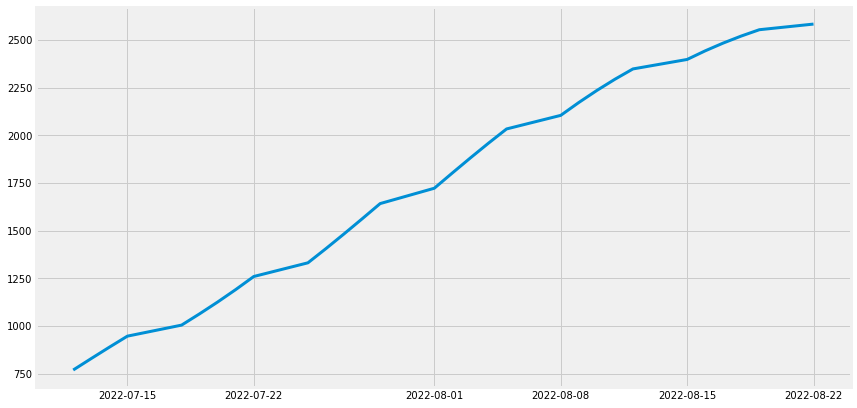

In [69]:
fig, ax = plt.subplots(1, figsize=(13, 7))
ax.plot(fut_preds, label="predicted value_30", linewidth=3)

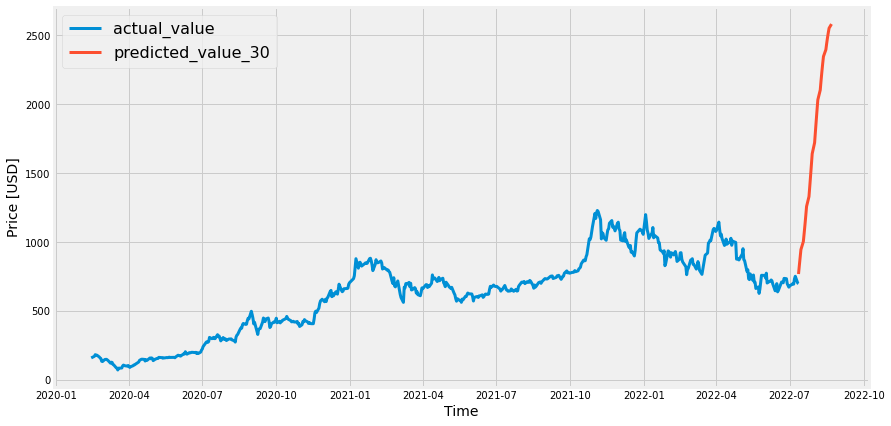

In [70]:
line_plot(test["close"], fut_preds, 'actual_value', 'predicted_value_30', lw=3)